In [1]:
import sys
sys.path.insert(0,'..')
import simulacra.star
import simulacra.tellurics
from simulacra.star import PhoenixModel

import random
import numpy as np

import astropy.io.fits
import astropy.time as at

import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


<h1>An Introduction to Simulating Spectrograph Data</h1>
This package should be used to simulate spectrographs by creating a star with a given flux, various transmission models (gas cell and tellurics), and a detector. Then simulating the detector at given start times for an exposure time.

### Theory
$$ F^{tot}_{ij} = Spline(x^{new}_j + \Delta(v_i) | x^s_{ij}, f^s_{ij}) \prod_{k \in T} Spline(x^{new}_j | x^k_{ij}, f^k_{ij})$$

$$ F^{lsf}_{ij} = k(R(\lambda_j)) \otimes F^{tot}_{ij}$$

$$ F^{det}_{\lambda ij} = Lanc(x^{det}_{j} | x^{new}_j, F^{lsf}_{ij}, a)$$ <br>

$$ N^{exp}_{ij} = F^{det}_{\lambda ij} t_{exp} A_{det}  \frac{R^2_{ste}}{D^2_{ste}} d \lambda_j$$

### Generating
Inside the detector, there is one stellar model that generates emission spectra, then a list of transmission models that are multiplied together to get this expected number of photons. The star model should output from `generate_spectra` three items: a 1d array of wavelength, a 1d array of flux in astropy units, and a 1d array of radial velocities at the given times. Once all the transmission grids are generated. Then lowest median grid spacing is used to a generate a new wavelength grid with equal spacing in log lambda space. Then all the transmission grids and spectra grid are interpolated onto the new grid using cubic splines. Finally these grids are multiplied element-wise to create the total theoretical flux. Now it's time to convolve the total flux with line spread function of the detector. This line spread function should be able to change over the pixel elements or the epoches. Once convolved, this is sampled at the `wave_grid` of the detector using Lanczos `a` Interpolation. This is the expected flux per pixel, which is convert to the expected number of photons using the above formula. d lambda is the difference over wavelength that is being measured at that ccd pixel. This can be set by the user but by default it takes element-wise differences and cates with the average. 


### Error Generating Process
c: read noise <br>
d: dark current <br>
Q: ccd efficiency <br>
f^{exp}: expected flux in photon number <br>
f^{readout}: readout flux in photon number

$$ SNR^{true}_{ij} = \frac{Q_j N^{exp}_{ij}}{\sqrt{c_j + d_j t_{exp} + Q_j N^{exp}_{ij}}} $$ <br>
$$ n_{ij} \sim Normal(0., N^{exp}_{ij}/SNR^{true}_{i,j}) $$ <br>
$$ N^{readout}_{ij} = N^{exp}_{ij} + n_{ij}$$ <br>
$$ SNR^{readout}_{ij} = \frac{Q_j N^{readout}_{ij}}{\gamma \sqrt{c_j + d_j t_{exp} + Q_j N^{readout}_{ij}}}$$ <br>
$$ \sigma^{N}_{ij} = \frac{N^{readout}_{ij}}{SNR^{readout}_{ij}} $$
Most in Nexp dominanted regime

through put 20%

1_000_000 photons is more normal.

this formula converts from the stellar flux denisty to the expected photon number on the detector.

In [2]:
ra, dec = np.random.uniform(0,360) * u.degree, np.random.uniform(0,80) * u.degree
obs = 'APO'
loc = coord.EarthLocation.of_site(obs)
target = coord.SkyCoord(ra,dec,frame='icrs')

Functions from the star module can be used to select times to view a given star from some observatory.

In [3]:
tstart = at.Time('2020-01-01T08:10:00.123456789',format='isot',scale='utc')
tend   = tstart + 180 * u.day
night_grid = simulacra.star.get_night_grid(loc,tstart,tend,steps_per_night=5)
possible_times, airmass = simulacra.star.get_realistic_times(target,loc,night_grid)

In [4]:
epoches = 3

Now we selected some random sample of these to observe at and the airmasses at those times

In [5]:
obs_ints = random.sample(range(len(airmass)),epoches)
obs_times, obs_airmass = possible_times[obs_ints], airmass[obs_ints]

<h2>Star Model</h2>
Here we define the star model with some temperature, distance, logg, and companion parameters. The logg, T, z, and alpha parameters must correspond to an appropriate atmosphere model from the PHOENIX libraray online. Then also give it some companion parameters that could affect its velocity. This is what we will be trying to find use jabble.

z is metallicity. And distance can be set to whatever you want.

In [1]:
from ftplib import FTP

ftp = FTP('phoenix.astro.physik.uni-goettingen.de') #logs in
ftp.login()

'230-Welcome, archive user!\n230-\n230-The local time is: Thu Nov 11 01:47:28 2021\n230-\n230-This is the FTP server for the spectra of the \n230-        GÃ¶ttingen Spectral Library\n230-        powered by PHOENIX\n230-\n230-More information at:\n230-        http://phoenix.astro.physik.uni-goettingen.de/\n230-\n230-Please cite our publication:\n230-        2013A&A...553A...6H\n230-\n230-If you have any unusual problems, please report them via e-mail to \n230-<husser@astro.physik.uni-goettingen.de>.\n230 Anonymous access granted, restrictions apply'

In [6]:
logg = 1.0
T    = 4800
z    = -1.0
alpha= 0.4
distance  = 100 * u.pc
amplitude = 10 * u.m/u.s
period    = 7 * u.day
stellar_model = PhoenixModel(distance,alpha,z,T,logg,target,amplitude,period)

using saved wave file
../data/stellar/PHOENIX/lte04800-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
reading in ../data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


In [3]:
import os.path

In [7]:
from simulacra.detector import Detector, spacing_from_res

In [6]:
z = -1.0
alpha = 0.4
directories = ['data','HiResFITS','PHOENIX-ACES-AGSS-COND-2011','Z{:+.1f}'.format(z) + '.Alpha={:+.2f}'.format(alpha)]
for directory in directories[]:
    ftp.cwd(os.path.join(directory))
    ftp.retrlines('LIST')

drwxr-xr-x  54 ftp      ftp          4096 May  9  2013 PHOENIX-ACES-AGSS-COND-2011
-rw-r--r--   1 ftp      ftp      12556800 May 10  2013 WAVE_PHOENIX-ACES-AGSS-COND-2011.fits
drwxr-xr-x   2 ftp      ftp         98304 May  9  2013 Z-0.0
drwxr-xr-x   2 ftp      ftp         57344 Apr 19  2013 Z-0.0.Alpha=-0.20
drwxr-xr-x   2 ftp      ftp         61440 Dec 31  2012 Z-0.0.Alpha=+0.20
drwxr-xr-x   2 ftp      ftp         61440 Apr 19  2013 Z-0.0.Alpha=+0.40
drwxr-xr-x   2 ftp      ftp         61440 Apr 19  2013 Z-0.0.Alpha=+0.60
drwxr-xr-x   2 ftp      ftp         61440 Apr 19  2013 Z-0.0.Alpha=+0.80
drwxr-xr-x   2 ftp      ftp         53248 Apr 19  2013 Z-0.0.Alpha=+1.00
drwxr-xr-x   2 ftp      ftp         57344 Apr 19  2013 Z-0.0.Alpha=+1.20
drwxr-xr-x   2 ftp      ftp         94208 Apr 19  2013 Z-0.5
drwxr-xr-x   2 ftp      ftp         90112 Apr 19  2013 Z+0.5
drwxr-xr-x   2 ftp      ftp         61440 Apr 19  2013 Z-0.5.Alpha=-0.20
drwxr-xr-x   2 ftp      ftp         61440 Apr 19  2013 Z-

-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06100-3.50-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06100-4.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06100-4.50-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06100-5.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06100-5.50-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06100-6.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06200-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r--   1 ftp      ftp       6287040 Feb 20  2013 lte06200-1.50-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
-rw-r--r

<h2>Detector</h2>
Here we define our detector giving it an aperature area, resolution, dark current, read noise, and ccd efficiency. All of these can be except area can be given as an array of the same size as the wave_grid (eg. if the detector has varying resolution or noise levels)

In [8]:
wave_min = 620 * u.nm
wave_max = 630 * u.nm

<h3>So your resolution varies across the detector?</h3>
Define resolution as a callable function that takes a wavelength grid in astropy units and outputs a resolution!

In [9]:
class Resolution_Func:
    def __init__(self,R_max,R_min,w_min,w_max):
        self.R_max = R_max
            
        
        self.w_med = (w_max + w_min)/2
        self.w_dif = (w_max - w_min)/2
        self.R_dif = (R_max - R_min)
        
        self.a = self.R_dif / self.w_dif**2
    
    
    def __call__(self,wavelength):
        return -self.a * (wavelength - self.w_med)**2 + self.R_max

In [10]:
# resolution = 100_000.0

area = np.pi*(4.3 * u.m/2)**2
exp_times = 8 * np.ones(epoches)* u.minute 
dark_current = 1/u.s
read_noise   = 1
ccd_eff      = 0.99
through_put  = 0.05

epsilon = 1.0
w = 1.5

gamma = 1.0

delta_x = spacing_from_res(2*100_000)
x_grid = np.arange(np.log(wave_min.to(u.Angstrom).value),np.log(wave_max.to(u.Angstrom).value),delta_x)
wave_grid = np.exp(x_grid) * u.Angstrom

res = Resolution_Func(R_min=100_000,R_max=130_000,w_min=np.min(wave_grid),w_max=np.max(wave_grid))

detector = Detector(stellar_model,res,loc,area,wave_grid,dark_current,read_noise,ccd_eff,through_put,gamma=gamma,epsilon=epsilon,w=w)

In [11]:
import matplotlib.pyplot as plt

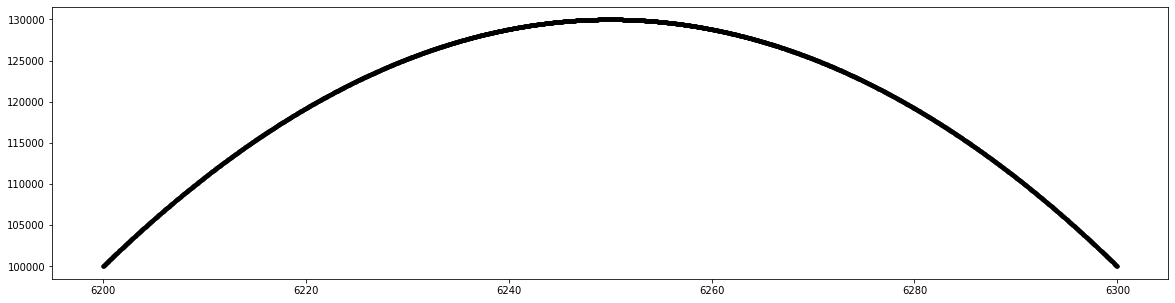

In [12]:
plt.figure(figsize=(20,5))
plt.plot(wave_grid,res(wave_grid),'.k')
plt.show()

<h2>Simulator</h2>
Now comes the bulk of the work, run the simulation with the given transmission models, star, detector at the given times for some exposure times.

In [13]:
data = detector.simulate(obs_times,exp_times)

surface flux: mean 1.31e+14 erg / (cm3 s)	 median 1.14e+14 erg / (cm3 s)
obs     flux: mean 3.78e-02 erg / (cm3 s)	 median 3.28e-02 erg / (cm3 s)
generating spectra...
interpolating spline...
3
1569128
combining grids...
convolving...
0
1
2
xs: 6195.0 6304.99366709246
xhat: 6199.991287579206 6300.003348491742
interpolating lanczos...
0
1
2
area: 14.522012041218817 m2	 avg d lambda: 0.031249249221739033 Angstrom	 avg lambda: 6249.865511192355 Angstrom	 avg exp times: 8.0 min
0 n mean: 1.68e+08	 n median: 1.74e+08
1 n mean: 1.68e+08	 n median: 1.74e+08
2 n mean: 1.68e+08	 n median: 1.74e+08
generating true signal to noise ratios...
adding noise...
generating exp signal to noise ratios...
generating errors...
done.


In [14]:
(14 * u.m**2 * 0.03 * u.Angstrom * 6300 * u.Angstrom * 8 * u.min * 324 * u.erg/(u.s*u.cm**3) /(const.hbar * const.c)).to(1)

<Quantity 1.30160505e+13>

Save file to pickle jar

In [ ]:
print(target)

In [ ]:
import matplotlib.pyplot as plt
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

In [ ]:
sigma = 200
n_plots = 3
plt_unit = u.Angstrom
sort_times = np.argsort(obs_times)
fig, axes = plt.subplots(n_plots,figsize=(20,5 * n_plots),sharex=True,sharey=True)

fig.text(0.5, 0.04, 'Wavelength [{}]'.format(plt_unit), ha='center', va='center')
fig.text(0.06, 0.5, 'Flux', ha='center', va='center', rotation='vertical')
for i in range(n_plots):
#     axes[i].set_xlim(np.log(6297),np.log(6300))
#     axes[i].set_ylim(-1.2,1.2)
    print('{:3.2e}'.format(np.mean(data['data']['flux'][i,:])),'{:3.2e}'.format(np.mean(data['data']['ferr'][i,:])))
    axes[i].errorbar(np.log(data['data']['wave'].to(u.Angstrom).value),data['data']['flux'][i,:],yerr=data['data']['ferr'][i,:],fmt='.k',alpha=0.5)
#     data.plot_data(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_tellurics(axes[i],sort_times[i],xy='x',units=plt_unit)#,normalize=normalize,nargs=[sigma]
#     data.plot_gas(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_theory(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_lsf(axes[i],sort_times[i],xy='x',units=plt_unit)
#     data.plot_star(axes[i],sort_times[i],xy='x',units=plt_unit)
# plt.savefig('out/datatest5.png')
plt.show()

In [15]:
outdir = ''
filename = '../out/data_e{}_R{}_a{}_p{}_l{:3.1e}{:3.1e}_ep{}_w{}_snr{:2.1e}'.format(epoches,resolution,\
                                                                amplitude.to(u.m/u.s).value,\
                                                                period.to(u.day).value,\
                                                                detector.lambmin.value,\
                                                                detector.lambmax.value,\
                                                               epsilon,w,np.mean(data['data']['snr_readout']))
print(filename)
data.to_pickle(filename + '.pkl')
data.to_h5(filename + '.h5')

NameError: name 'resolution' is not defined

In [ ]:
from simulacra.dataset import print_keys
print_keys(data)

In [ ]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s
plt.plot((times - min(times)).to(u.day).value % period.to(u.day).value,eprv.to(v_unit).value,'.r')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()